<a href="https://colab.research.google.com/github/WillemBlokland/datamining-report/blob/main/notebook_met_weighted_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.simplefilter('ignore')


DF = pd.read_csv("data/heart.csv")
DF_Shape = {"Total Rows": [len(DF.index)], "Total Columns": [len(DF.columns)]}
DF_Shape = pd.DataFrame(DF_Shape,index=["Values"])
DF_Shape.transpose()

Values
Total Rows       1025
Total Columns      14

In [19]:
index = list(DF.columns)
new_df = pd.DataFrame(index=index)
for col in DF.columns:
    new_df.at[col,'data_type'] = DF[col].dtypes
    new_df.at[col,'null_count'] = DF[col].isnull().sum()
    new_df.at[col,'unique_value'] = DF[col].nunique()
    new_df.at[col,'min_value'] = DF[col].min()
    new_df.at[col,'mean_value'] = round(DF[col].mean(),0)
    new_df.at[col,'max_value'] = DF[col].max()
new_df

data_type  null_count  unique_value  min_value  mean_value  max_value
age          int64         0.0          41.0       29.0        54.0       77.0
sex          int64         0.0           2.0        0.0         1.0        1.0
cp           int64         0.0           4.0        0.0         1.0        3.0
trestbps     int64         0.0          49.0       94.0       132.0      200.0
chol         int64         0.0         152.0      126.0       246.0      564.0
fbs          int64         0.0           2.0        0.0         0.0        1.0
restecg      int64         0.0           3.0        0.0         1.0        2.0
thalach      int64         0.0          91.0       71.0       149.0      202.0
exang        int64         0.0           2.0        0.0         0.0        1.0
oldpeak    float64         0.0          40.0        0.0         1.0        6.2
slope        int64         0.0           3.0        0.0         1.0        2.0
ca           int64         0.0           5.0        0.0         1.0        4.0
thal         int64         0.0           4.0        0.0         2.0        3.0
target       int64         0.0           2.0        0.0         1.0        1.0

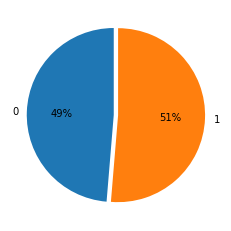

In [20]:
DF['Count'] = 1
target = pd.pivot_table(DF, values='Count', index=['target'], aggfunc = np.sum).fillna(0).reset_index()
DF.drop(['Count'], axis=1, inplace=True)
plt.pie(target['Count'], labels=target['target'], autopct='%1.0F%%', startangle=90, explode=(0.025,0.025))
plt.show()

In [21]:
df,Y,T,F = DF,'target',1,0
DF4 = pd.DataFrame()
for col in df.columns:
    if col != Y:
        X = str(col)
        data = df[[Y,X]]
        Z = X + '_grp'
        data[Z] = data[X]
        data['Count'] = 1
        table = pd.pivot_table(data, values='Count', index=[Z], columns=[Y], aggfunc=np.sum).fillna(0).reset_index()
        table['True%'] = (table[T] / (table[T] + table[F]))
        table['False%'] = (table[F] / (table[T] + table[F]))
        A = Z + '_Weightage'
        table[A] = round((table['True%']) - (table['False%']),2)
        table2 = table.set_index(Z)
        table2 = table2[[A]]
        data2 = data[Z]
        DF2 = DF.join(data2)
        DF3 = pd.merge(DF2, table2, left_on=Z, right_index=True)
        DF4[A] = DF3[A]
DF4['Total_Weightage'] = 0
DF4['Total_Weightage'] = DF4.sum(axis = 1, skipna = True)
A_DF = DF.iloc[:,-1]
DF5 = DF4.join(A_DF)

In [22]:
BenMar = DF5['Total_Weightage'].quantile(0.46)
round(BenMar,2)

0.09

In [66]:
for ix in DF5.index:
    if DF5.at[ix,'Total_Weightage'] <= BenMar:
        DF5.at[ix,'Pred'] = F
    else:
        DF5.at[ix,'Pred'] = T
round(accuracy_score(DF5['target'],DF5['Pred']),2)

0.93

In [67]:
x = DF.iloc[:,0:13]
y = DF.iloc[:,len(DF.columns)-1]
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=0)
logreg = LogisticRegression()
logreg.fit(x_train,y_train)
y_pred = logreg.predict(x_test)
round(accuracy_score(y_pred,y_test),2)

0.87

**Clearly the Weighted Model has better Accuracy Score**


In [25]:
!pip install pdpbox
!pip install shap
!pip install eli5

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #for plotting
from sklearn.ensemble import RandomForestClassifier #for the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz #plot tree
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
from sklearn.model_selection import train_test_split #for data splitting


from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots


import shap #for SHAP values
from pdpbox import pdp, info_plots #for partial plots

import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance

In [27]:
# Start writing code here...

#SVR is a regression algorithm, so not very useful here. Better then pick an SVM (or another classifier). 
#Just to make sure: ROC is a generic procedure for measuring/visualizing the performance of any classifier, not a classifier by itself.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import csv

#importing the dataset into a variable
dataset = pd.read_csv('data/heart.csv')

print(len(dataset))
print(dataset.head())
print(dataset.shape)
print(dataset.columns)

#Now we will drop the values that have na’s.
dataset.dropna()
print(dataset.shape)
# There appears to be no na's because the shape of the dataset does not change, which means no elements have been dropped.

# we change the column names for clearity and convenient use.
dataset.columns = ['age', 'sex', 'chest_pain', 'rest_bloodpressure', 'cholesterol', 'fasting_bloodsugar', 'rest_elec_cardio_graphic', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'number_major_vessels', 'thalassemia', 'target']

print(dataset.columns)

print(dataset.dtypes)

# We drop age because if you look closely at the age factor, there are very few young people, and they indeed have higher rates of disease. This clearly contradicts common sense and is most likely due to selection bias in the study. I would drop the age alltogether from any model.
dataset = dataset.drop(dataset.columns[[0]], axis=1)

print(dataset.tail())

1025
   age  sex  cp  trestbps  chol  fbs  ...  exang  oldpeak  slope  ca  thal  target
0   52    1   0       125   212    0  ...      0      1.0      2   2     3       0
1   53    1   0       140   203    1  ...      1      3.1      0   0     3       0
2   70    1   0       145   174    0  ...      1      2.6      0   0     3       0
3   61    1   0       148   203    0  ...      0      0.0      2   1     3       0
4   62    0   0       138   294    1  ...      0      1.9      1   3     2       0

[5 rows x 14 columns]
(1025, 14)
Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')
(1025, 14)
Index(['age', 'sex', 'chest_pain', 'rest_bloodpressure', 'cholesterol',
       'fasting_bloodsugar', 'rest_elec_cardio_graphic',
       'max_heart_rate_achieved', 'exercise_induced_angina', 'st_depression',
       'st_slope', 'number_major_vessels', 'thalassemia', 'target'],
      dtype='obje

In [65]:
# First we build a Decision Tree and print the corresponding f1 scores

# Building Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
X_train ,X_test, y_train, y_test= train_test_split(dataset.drop('target', 1), dataset['target'], test_size = .2, random_state=10)
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)


# Evaluation on Training set
dtc_pred_train = dtc.predict(X_train)
print('Training Set Evaluation F1-Score=>',f1_score(y_train,dtc_pred_train))

# Evaluating on Test set
dtc_pred_test = dtc.predict(X_test)
print('Test Set Evaluation F1-Score=>',f1_score(y_test,dtc_pred_test))


Training Set Evaluation F1-Score=> 1.0
Test Set Evaluation F1-Score=> 1.0


In [29]:
# Now we build a Random Forest Classifier and also print its corresponding f1 scores, and we compare them to the scores of
# the decision tree

# Building  Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

# Evaluating on Training set
rfc_pred_train = rfc.predict(X_train)
print('Training Set Evaluation F1-Score=>',f1_score(y_train,rfc_pred_train))
# Evaluating on Test set
rfc_pred_test = rfc.predict(X_test)
print('Testing Set Evaluation F1-Score=>',f1_score(y_test,rfc_pred_test))

Training Set Evaluation F1-Score=> 1.0
Testing Set Evaluation F1-Score=> 1.0


### they both get the same scores for the training and testing set, so it seems that it doesnt really matter which one we use. We choose to use the random forest classifier because the random forests (classiefier) combines the simplicity of decision trees with fexibility resulting in a vast improvement in accuracy.


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #for plotting
from sklearn.ensemble import RandomForestClassifier #for the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz #plot tree
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
from sklearn.model_selection import train_test_split #for data splitting


In [32]:
# We create and print the random forest tree classiefier on our dataset
# Max depth is set to 5 to prevent overfitting (which happens at max depth > 5)

X_train, X_test, y_train, y_test = train_test_split(dataset.drop('target', 1), dataset['target'], test_size = .2, random_state=42)

model = RandomForestClassifier(max_depth=5)
model.fit(X_train, y_train)

estimator = model.estimators_[1]
feature_names = [i for i in X_train.columns]

y_train_str = y_train.astype('str')
y_train_str[y_train_str == '0'] = 'no disease'
y_train_str[y_train_str == '1'] = 'disease'
y_train_str = y_train_str.values

export_graphviz(estimator, out_file='tree.dot', 
                feature_names = feature_names,
                class_names = y_train_str,
                rounded = True, proportion = True, 
                label='root',
                precision = 2, filled = True)


# Now that the random forest is stored in the tree.dot file, lets create an image from the file for visualisation:

from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'test.png', '-Gdpi=600'], shell=True)

from IPython.display import Image
Image(filename = 'tree.png')

### This forest classifier looks good, lets now create the confusion matrix and its sensitifity and specificity values


In [33]:

y_predict = model.predict(X_test)
y_pred_quant = model.predict_proba(X_test)[:, 1]
y_pred_bin = model.predict(X_test)

confusion_matrix = confusion_matrix(y_test, y_pred_bin)
confusion_matrix


array([[79, 23],
       [ 7, 96]])

In [34]:
total=sum(sum(confusion_matrix))

sensitivity = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[1,0])
print('Sensitivity : ', sensitivity )

specificity = confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[0,1])
print('Specificity : ', specificity)

Sensitivity :  0.9186046511627907
Specificity :  0.8067226890756303


0.9540262707024557

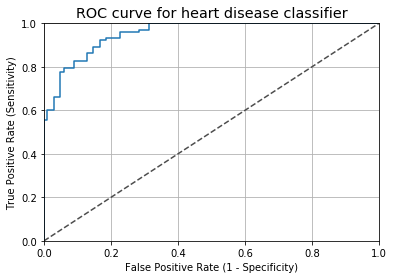

In [35]:
# Plotting the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_quant)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for heart disease classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

auc(fpr, tpr)

Another common metric is the **Area Under the Curve**, or **AUC**. This is a convenient way to capture the performance of a model in a single number, although it's not without certain issues. As a rule of thumb, an AUC can be classed as follows,

- 0.90 - 1.00 = excellent
- 0.80 - 0.90 = good
- 0.70 - 0.80 = fair
- 0.60 - 0.70 = poor
- 0.50 - 0.60 = fail

The ROC gives us:

In [36]:
auc(fpr, tpr)

0.9540262707024557

## The score is in the excellent range, so is works well. The accuracy of this model is good.

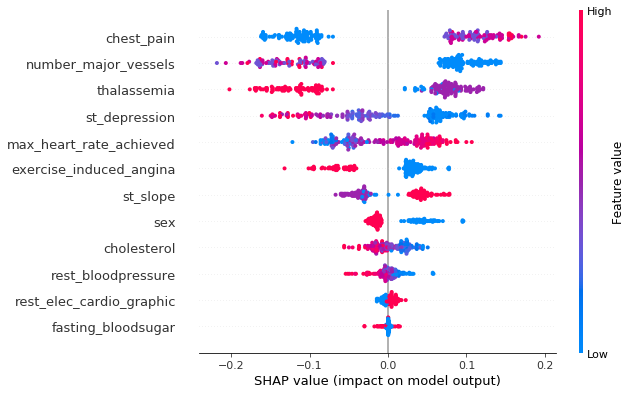

In [38]:
shap.summary_plot(shap_values[1], X_test)

In [39]:
# #individuelen mensen
# #op een of andere manier werkt dit niet online, als we willen zien moeten we jupyter notebook gebruiken denk

# def heart_disease_risk_factors(model, patient):

#     explainer = shap.TreeExplainer(model)
#     shap_values = explainer.shap_values(patient)
#     shap.initjs()
#     return shap.force_plot(explainer.expected_value[1], shap_values[1], patient)

# data_for_prediction = X_test.iloc[1,:].astype(float)
# heart_disease_risk_factors(model, data_for_prediction)

In [40]:
# shap_values = explainer.shap_values(X_train.iloc[:50])
# shap.force_plot(explainer.expected_value[1], shap_values[1], X_test.iloc[:50])

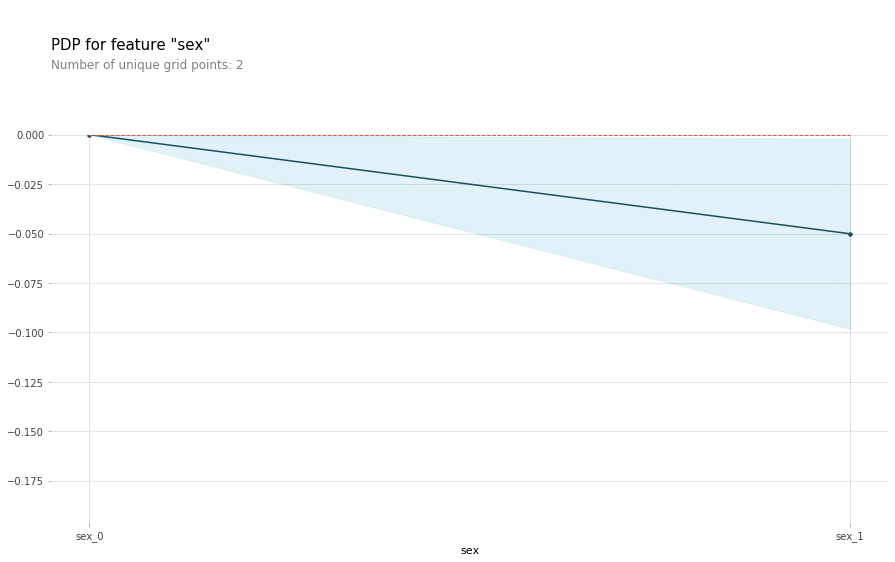

In [49]:
base_features = dataset.columns.values.tolist()
base_features.remove('target')

feat_name = 'sex'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

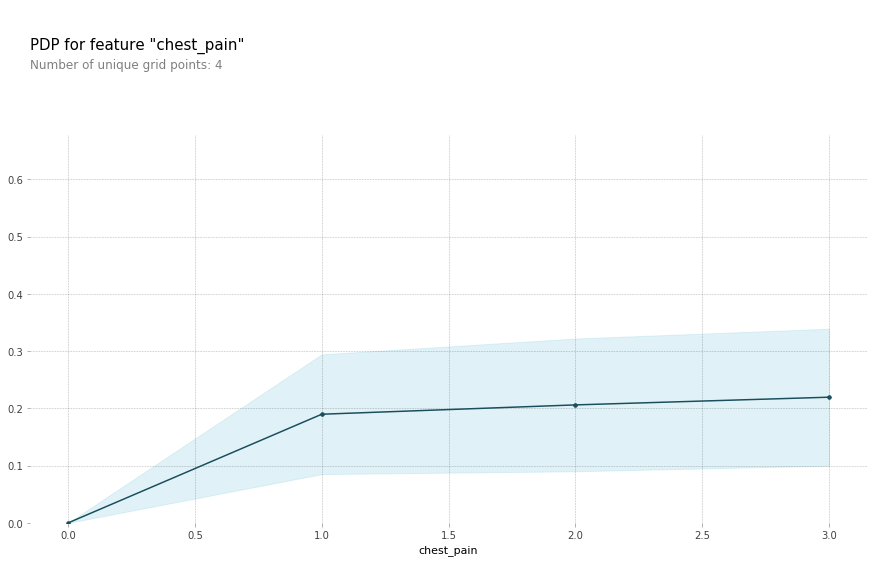

In [44]:

feat_name = 'chest_pain'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

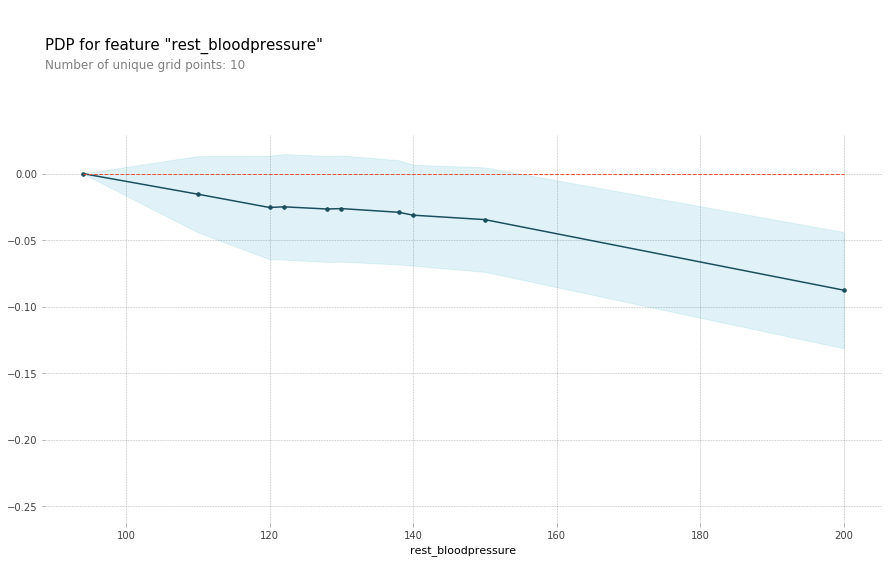

In [45]:
feat_name = 'rest_bloodpressure'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

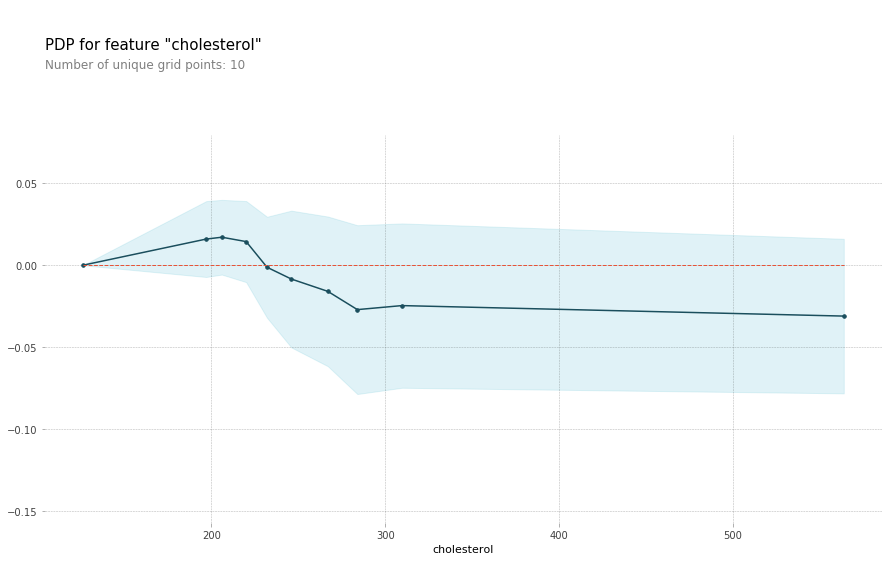

In [46]:
feat_name = 'cholesterol'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

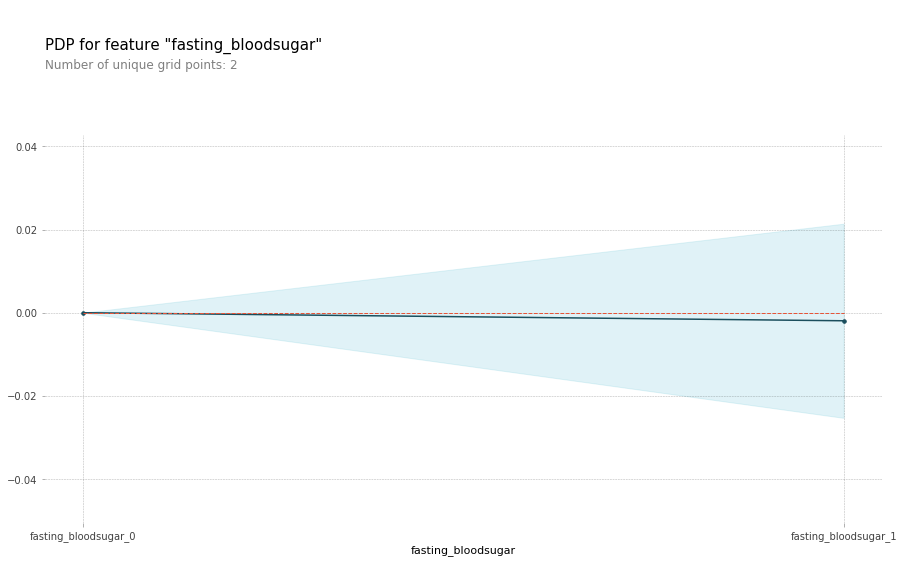

In [48]:
feat_name = 'fasting_bloodsugar'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

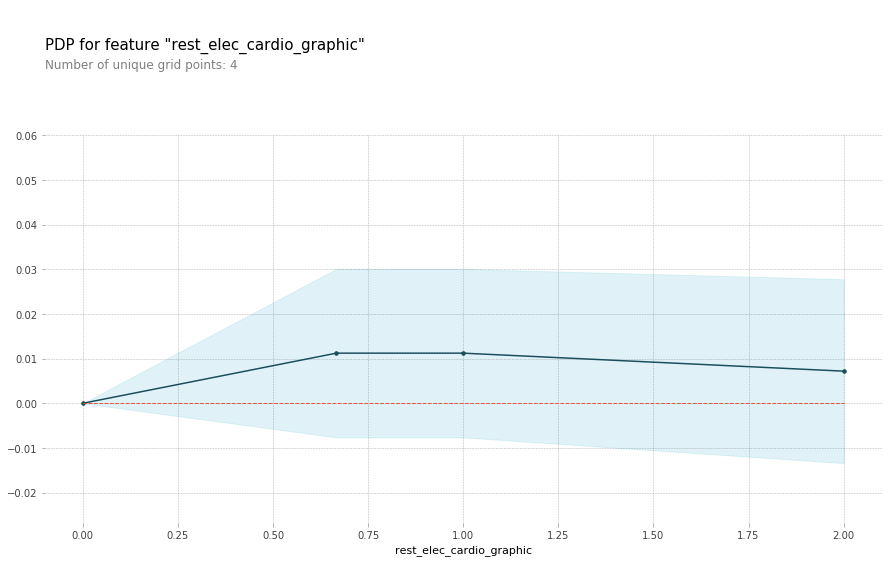

In [50]:
feat_name = 'rest_elec_cardio_graphic'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

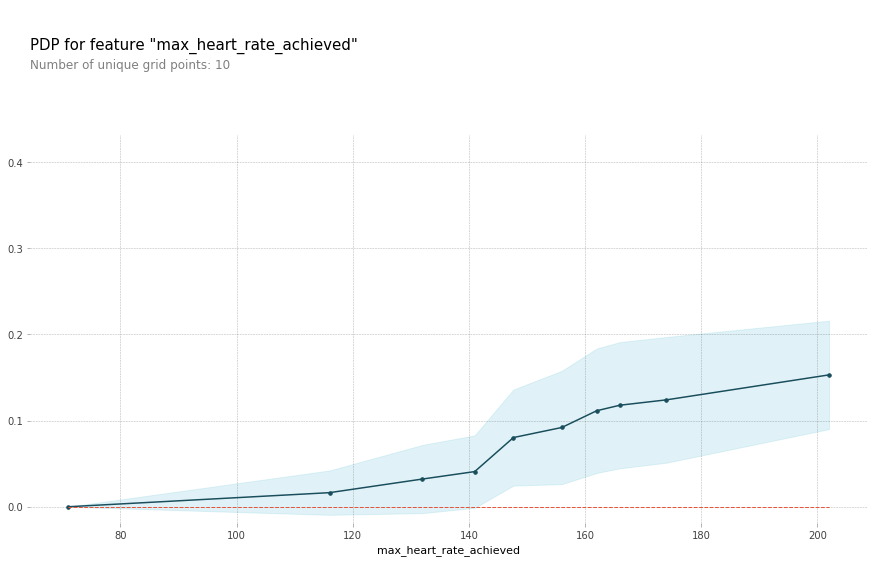

In [51]:
feat_name = 'max_heart_rate_achieved'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

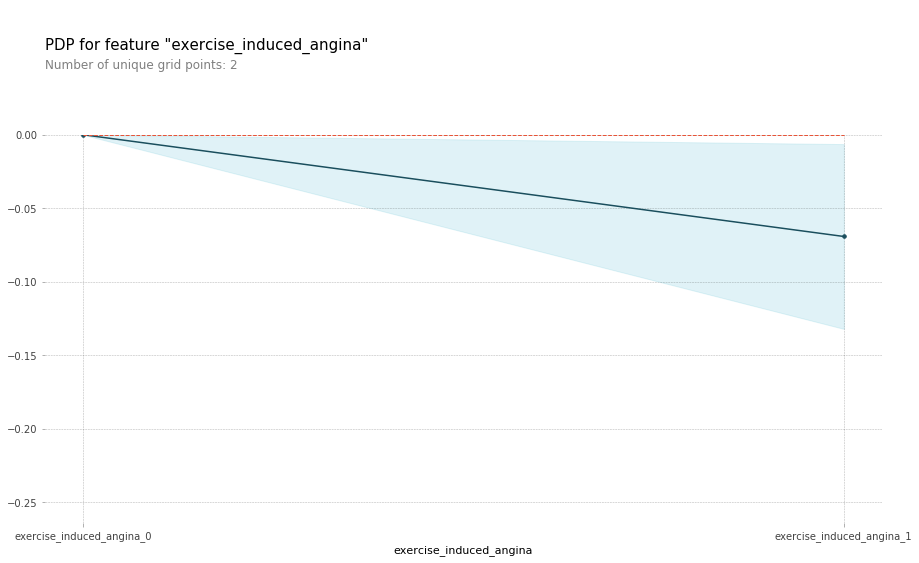

In [53]:
feat_name = 'exercise_induced_angina'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

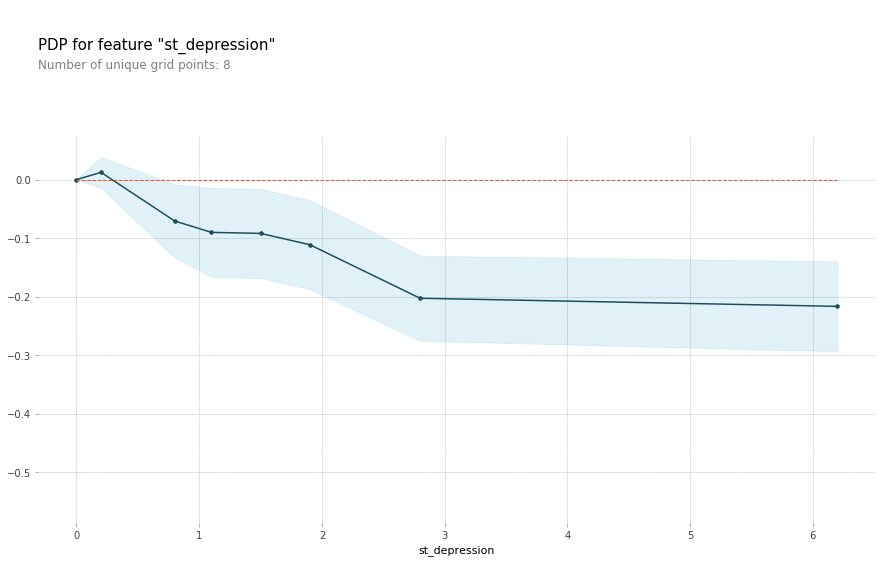

In [54]:
feat_name = 'st_depression'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

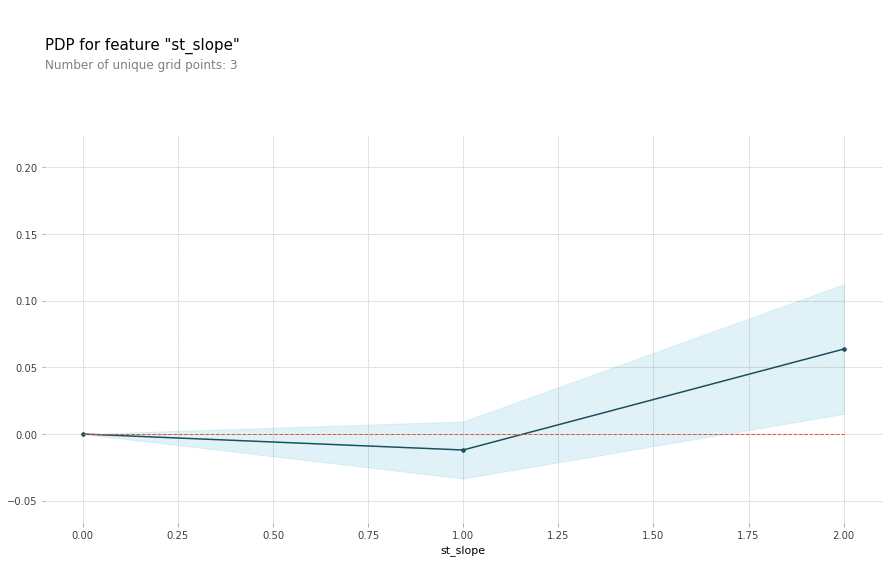

In [55]:
feat_name = 'st_slope'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

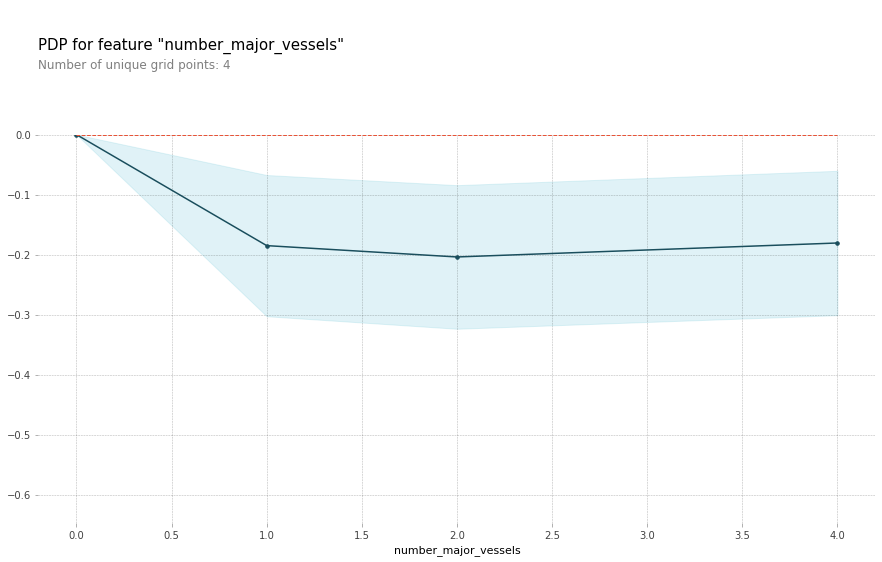

In [56]:
feat_name = 'number_major_vessels'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

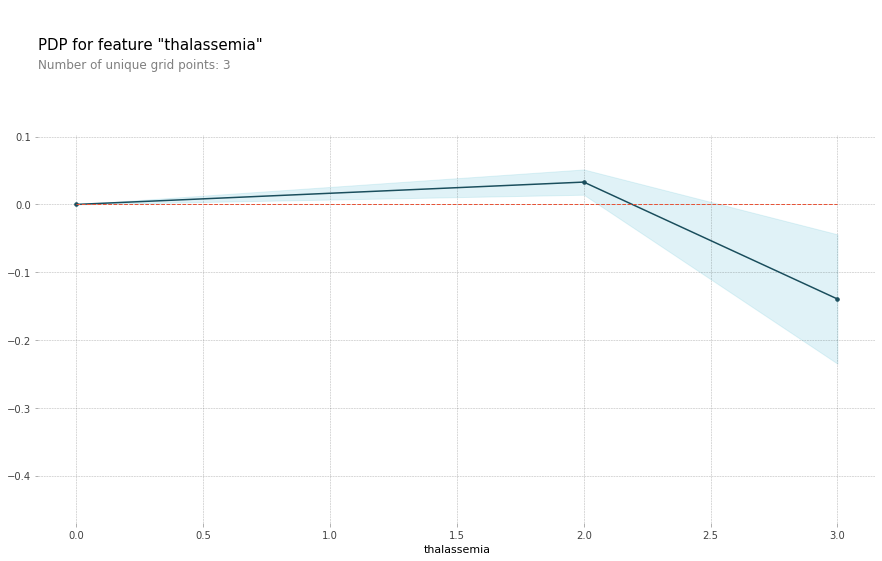

In [63]:
feat_name = 'thalassemia'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)
pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

## We can use shap to build a plot which shows the attributes that have the most impact on the target value ( whether a person has a heart disease or not)

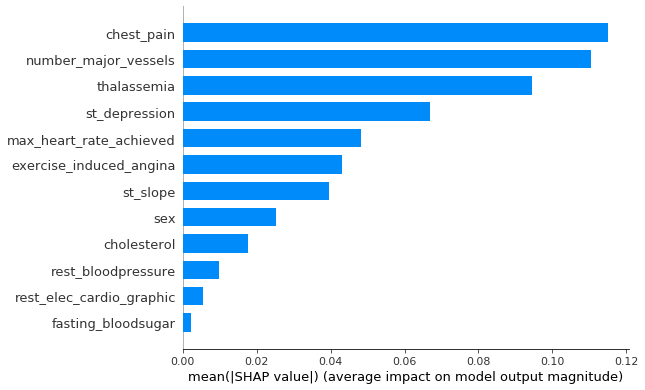

In [62]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], X_test, plot_type="bar")

https://medium.com/@aqureshi/using-support-vector-machine-svm-classifier-in-python-to-predict-heart-disease-with-framingham-fed646b97067

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0e31d014-ef6d-4d71-8cc3-e562c64193b1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>